# EJERCICIO 9
La segmentación de imágenes digitales en regiones con apariencia de piel ha sido utilizado como un paso de pre-procesamiento en varias aplicaciones de detección y seguimiento de caras humanas y personas.
Con el fin de generar un detector de piel/no-piel, se realizó un muestreo de fotografías digitales de caras de personas de diversas edades, géneros y razas al mismo tiempo que se hizo otro muestreo de imágenes que no incluyeran personas. El muestreo consistió en obtener mediciones del color de pixels de cada una de las clases requeridas (piel/no-piel). La medición del color se realizó en el espacio de colores RGB, obteniendo un total de 51444 muestras de las cuales 14654 son muestras de piel mientras que las restantes 36790 son muestras de otras texturas. Cada muestra está representada por el nivel de azul (B), verde (G) y rojo (R), siendo el nivel un valor entero entre 0 (mínimo nivel posible) y 255 (máximo nivel posible).
Entrene una red neuronal artificial para tratar de predecir a partir del color de un pixel dado si se trata o no de piel humana. Utilice todas las muestras para el entrenamiento.
Detalle la arquitectura empleada y los valores de los parámetros usados. Documente todos los intentos realizados. Informe los mejores resultados obtenidos. Utilice la imagen suministrada junto con el enunciado para validar la efectividad del clasificador.

In [1]:
import pyximport; pyximport.install()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import pylab
import mpld3
%matplotlib inline
mpld3.enable_notebook()
from utils.cperceptron import Perceptron
from utils.cbackpropagation import ANN #, Identidad, Sigmoide
import utils.patrones as magia

def progreso(ann, X, T, y=None, n=-1, E=None):
    if n % 20 == 0:
        print("Pasos: {0} - Error: {1:.32f}".format(n, E)) 
def progresoPerceptron(perceptron, X, T, n):
    y = perceptron.evaluar(X)
    incorrectas = (T != y).sum()
    print("Pasos: {0}\tIncorrectas: {1}\n".format(n, incorrectas))

In [2]:
piel = np.load('resources/piel.npy')

color = piel[:, :-1]
tipos = piel[:, -1]
# tipos == 1 --> Piel
# tipos == 2 --> No Piel

In [3]:
#Armo Patrones
clases, patronesEnt, patronesTest = magia.generar_patrones(
    magia.escalar(color),tipos,90)
X, T = magia.armar_patrones_y_salida_esperada(clases,patronesEnt)
Xtest, Ttest = magia.armar_patrones_y_salida_esperada(clases,patronesTest)

# Esto es para poder usar Cython y que sea mas rapido
X = X.astype(np.float)
Xtest = Xtest.astype(np.float)
TT = T[:,0].copy(order='C')
TT = TT.astype(np.int8)

utils/patrones.py:84: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X = np.vstack(patrones[c] for c in clases)


## Prueba con Perceptron

In [4]:
p1 = Perceptron(X.shape[1])
p1.reiniciar()
I1 = p1.entrenar(X, TT, max_pasos=10000, callback=progresoPerceptron, frecuencia_callback=5000)
print("Pasos:{0}".format(I1))

Pasos: 5000	Incorrectas: 13188

Pasos: 10000	Incorrectas: 13188

Pasos:10000


In [5]:
print("Errores:{0} de {1}".format((p1.evaluar(Xtest) != Ttest[:,0]).sum(),Ttest.shape[0]))

Errores:1466 de 5145


## Prueba con BackPropagation

In [6]:
# Crea la red neuronal
ocultas = 8 #2,5,10(0.13),20(0.018),100(0.014),8(0.017)
entradas = X.shape[1]
salidas = T.shape[1]
ann = ANN(entradas, ocultas, salidas)
ann.reiniciar()

In [16]:
#Entreno
E, n = ann.entrenar_rprop(X, T, min_error=0, max_pasos=1000, callback=progreso, frecuencia_callback=100)
print("\nRed entrenada en {0} pasos con un error de {1:.32f}".format(n, E))

Pasos: 100 - Error: 0.20304703275694485631319707863440
Pasos: 200 - Error: 0.20304702909364308327511139395938
Pasos: 300 - Error: 0.20304702895992204902952948941675
Pasos: 400 - Error: 0.20304702892170389816328679444268
Pasos: 500 - Error: 0.20304702890768278056299322997802
Pasos: 600 - Error: 0.20304702889922598973981848757830
Pasos: 700 - Error: 0.20304702889516146324666578948381
Pasos: 800 - Error: 0.20304702889272355226246702386561
Pasos: 900 - Error: 0.20304702889114584207774782953493
Pasos: 1000 - Error: 0.20304702889000578180933587191248

Red entrenada en 1000 pasos con un error de 0.20304702889000578180933587191248


In [8]:
ann.evaluar(Xtest)

array([[0.28772698, 0.71226756],
       [0.28772698, 0.71226756],
       [0.28772698, 0.71226756],
       ...,
       [0.28772698, 0.71226756],
       [0.28772698, 0.71226756],
       [0.28772698, 0.71226756]])

In [9]:
#Evaluo
Y = (ann.evaluar(Xtest) >= 0.89)
magia.matriz_de_confusion(Ttest,Y) 

(array([[   0.,    0., 1466.],
        [   0.,   35., 3644.]]), [array([1, 0]), array([0, 1])])

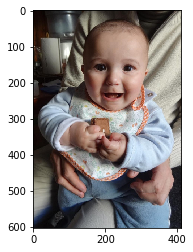

In [10]:
# Para probar el clasificador
imagen = np.load('resources/imagen.npy')
mpl.pylab.imshow(imagen)
# La imagen ahora en una matriz donde en cada fila está el color de cada pixel.
imagen_lineal = imagen.reshape(-1, 3)[:, ::-1]
foto = imagen_lineal.copy(order='C').astype(np.float64)

In [11]:
ann.evaluar(foto)

array([[0.08374641, 1.11930875],
       [0.08374641, 1.11930875],
       [0.09888819, 1.11641428],
       ...,
       [0.20701287, 1.0651862 ],
       [0.20956088, 1.06730247],
       [0.20956088, 1.06730247]])

In [12]:
#Evaluo
Y = (ann.evaluar(foto) >= 2).astype(np.int8)

In [13]:
fotoClasificada = Y[:,1].reshape(imagen.shape[:-1]).astype(np.int8)

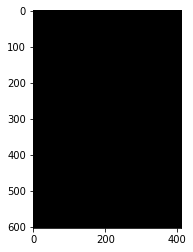

In [14]:
# Vuelve a darla las dimensiones de la imagen al resultado de la clasificación.
#clasificacion = Y.reshape(imagen.shape[:-1])
pylab.gray()
pylab.imshow(fotoClasificada)
pylab.show()

#LO BLANCO ES PIEL

In [18]:
ann.guardar('hitler')